<a href="https://colab.research.google.com/github/merriekay/CS167Code/blob/main/Day22_RNN_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network Lab

A lot of the code from this notebook comes from the book ['Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow', chapter 15](https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb).


## Set up:
Let's start off by generating some time-series data. The code below will:
- generate a time series
- set up training, validation, and testing data
- plot the data that was created

In [46]:
# Let's take care of input statements first.
import numpy as np
import keras
import tensorflow as tf
from tensorflow import keras
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")



Today, we will be generating our own data instead of using a dataset. The function below will generate a random time series dataset (a combination of two different waveforms plus some noise). The `generate_time_series` function will do this.

In [47]:
# first, let's use a function to generate some training data for us to use, let's use the time as input
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [48]:
# Now, let's use that function to generate some training, validation, and testing data
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [49]:
# (7000, 50 time steps, 1 value), (7000, the next timestep)
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

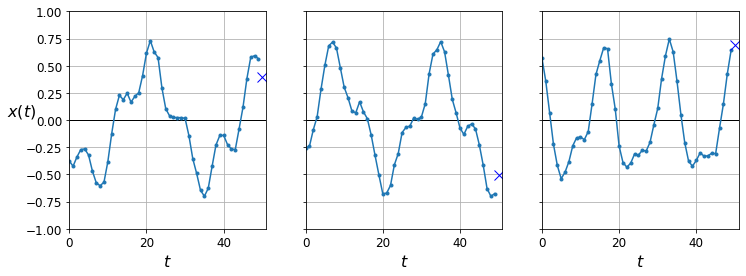

In [50]:
# Let's take a look at our data:
# This just prints the first 3 columns, but really there are 50 (one for each timestep)
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

In [51]:
# A helpful function to plot the learning curve.
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 10, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


## Basic Recurrent Neural Network:

In [10]:
#Build and describe the model 
# This is as simple as we can get, 1 RNN neuron
# Notice: the input shape is [None,1] The None means that it will take any sized input. The 1 means that it is a 1D series. 
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [11]:
#set up the optimizer, and train the model 
# If you're connected to a GPU, this should be about 10s per epoch.
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 29ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0117 - val_l

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0109


0.010881561785936356

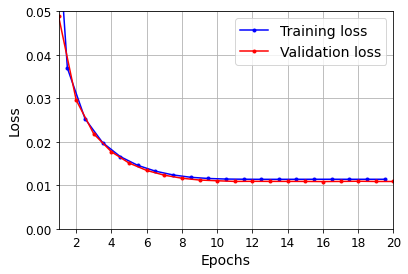

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

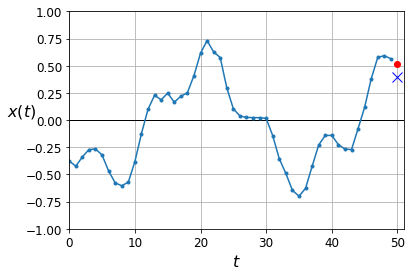

In [25]:
y_pred = model.predict(X_valid)
#plot all 50 timesteps of the first row of validation data as well as our prediction.
#our prediction is the red dot, the true value (y_valid) is shown as the X.
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs
Now, let's stack a few of these SimpleRNN layers on top of each other as well as include a few more neurons in each layer.

This will increase the training time, but also, hopefully, increase the accuracy of the model.


In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Train the model. 
# This one will take a bit more time, ~20 second per epoch
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 21s 90ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 19s 89ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 20s 89ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 20s 89ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 20s 89ms/step - loss: 0.003

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0029


0.002910560928285122

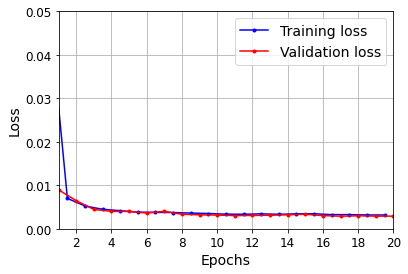

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

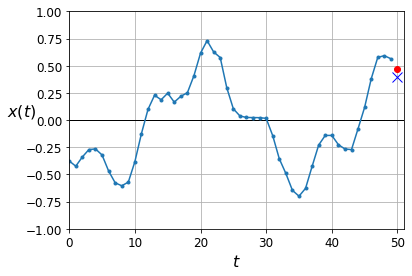

In [20]:
y_pred = model.predict(X_valid)
#plot all 50 timesteps of the first row of validation data as well as our prediction.
#our prediction is the red dot, the true value (y_valid) is shown as the X.
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [21]:
# Change the last layer to Dense instead of RNN
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 14s 61ms/step - loss: 0.0566 - val_loss: 0.0052
Epoch 2/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/10
219/219 [==============================] - 13s 60ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/10
219/219 [==============================] - 14s 62ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/10
219/219 [==============================] - 14s 62ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/10
219/219 [==============================] - 13s 60ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/10
219/219 [==============================] - 13s 59ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/10
219/219 [==============================] - 13s 60ms/step - loss: 0.002

In [23]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0029


0.0028929663822054863

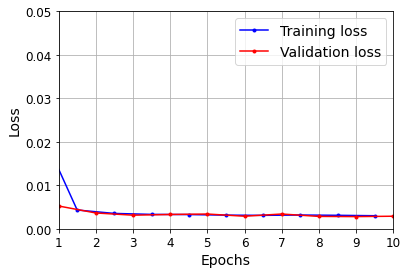

In [27]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

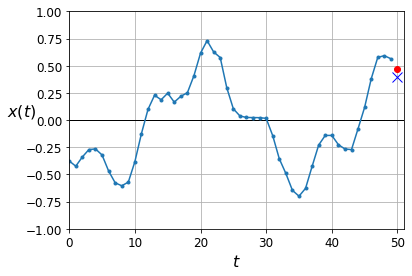

In [28]:
y_pred = model.predict(X_valid)
#plot all 50 timesteps of the first row of validation data as well as our prediction.
#our prediction is the red dot, the true value (y_valid) is shown as the X.
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting a few steps ahead:
Let's build a new series to predict a few steps ahead--instead of just one. First, we'll need to regenerate our series to include the next 10 timesteps.

In [29]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [30]:
Y_pred.shape

(1, 10, 1)

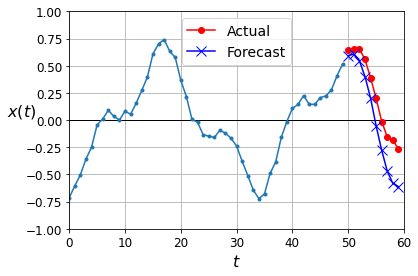

In [31]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [32]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [33]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [34]:
Y_pred.shape

(2000, 10)

In [35]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.04408642

## LSTMs
Okay, now, let's implement an LSTM.

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [56]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [57]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
    
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 10ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0515 - last_time_step_mse: 0.0326 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0407 - last_time_step_mse: 0.0196 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0356 - last_time_step_mse: 0.0156 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0330 - last_time_step_mse: 0.0138 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0313 - last_time_step_mse: 0.0124 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=======

In [61]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.02378869242966175, 0.00856081023812294]

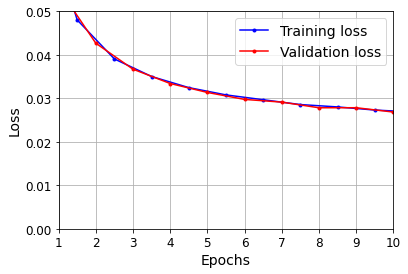

In [62]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [59]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

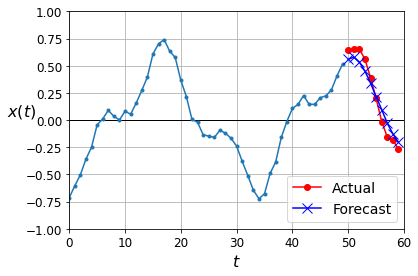

In [60]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## GRUs
Let's use GRUs this time. Notice the difference in training time


In [63]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 10ms/step - loss: 0.0995 - last_time_step_mse: 0.0940 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0495 - last_time_step_mse: 0.0383 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0432 - last_time_step_mse: 0.0321 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0379 - last_time_step_mse: 0.0261 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0333 - last_time_step_mse: 0.0192 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0310 - last_time_step_mse: 0.0158 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=======

In [64]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785503581166267, 0.010262807831168175]

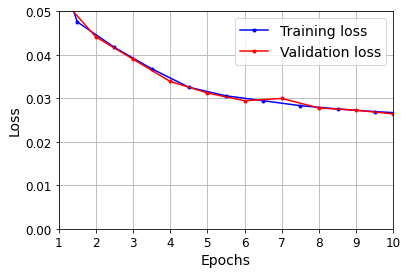

In [65]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [66]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

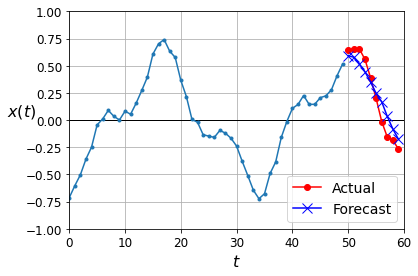

In [67]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Exercise
Your turn! Try to build a model that performs better than the models that we've created so far. 

In [ ]:
# Your code here. 